# Growth mixture models

In [1]:
%load_ext autoreload
%autoreload 2

import os

# For JAX, we can use CPU (set SELECTED_DEVICE to empty (''), or one of the available GPUs)
SELECTED_DEVICE = '1'
print(f'Setting CUDA visible devices to [{SELECTED_DEVICE}]')
os.environ['CUDA_VISIBLE_DEVICES'] = f'{SELECTED_DEVICE}'

Setting CUDA visible devices to [1]


In [2]:
import matplotlib.pyplot as plt

import jax
jax.config.update("jax_enable_x64", True)  # Do we need this here? -> it seems we do for the LML computations (otherwise NaNs get introduced), but not for performance

import jax.random as jrnd
import jax.numpy as jnp
import distrax as dx
import blackjax
import pandas as pd
import jax.scipy.special as jsp

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors


import os
import sys

from blackjax import normal_random_walk

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../../')))

import bamojax
from bamojax.base import Model
from bamojax.sampling import gibbs_sampler, smc_inference_loop, mcmc_sampler

print('Python version:       ', sys.version)
print('Jax version:          ', jax.__version__)
print('BlackJax version:     ', blackjax.__version__)
print('Distrax version:      ', dx.__version__)
print('BaMoJax version:      ', bamojax.__version__)
print('Jax default backend:  ', jax.default_backend())
print('Jax devices:          ', jax.devices())

SMALL_SIZE = 14
MEDIUM_SIZE = 16
LARGE_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=LARGE_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)  # fontsize of the figure title

Python version:        3.10.15 (main, Oct  3 2024, 07:27:34) [GCC 11.2.0]
Jax version:           0.4.35
BlackJax version:      1.2.4
Distrax version:       0.1.5
BaMoJax version:       0.0.1
Jax default backend:   gpu
Jax devices:           [CudaDevice(id=0)]


Start with a regular Gaussian mixture model

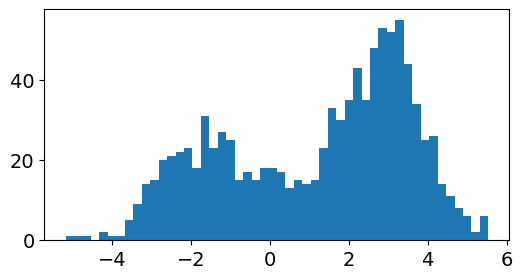

In [3]:
key = jrnd.PRNGKey(1234)

K = 3

y_dist = dx.MixtureSameFamily(mixture_distribution=dx.Categorical(probs=jnp.asarray([0.2, 0.3, 0.5])), components_distribution=dx.Normal(loc=jnp.asarray([-2, 0, 3]), scale=jnp.asarray([1.0, 2.0, 1.0])))
n = 1000

Y = y_dist.sample(seed=key, sample_shape=(n, ))

plt.figure(figsize=(6, 3))
plt.hist(Y, bins=50);

The parameters for `dx.MixtureSameFamily` are distrax distributions - how to pass these?

In [4]:
def centered_softmax(v):
    return jax.nn.softmax(jnp.insert(v, 0, 0, axis=0))

#
def gmm_link_fn(w_raw, mu, sd):
    w = centered_softmax(w_raw)
    return dict(mixture_distribution=dx.Categorical(probs=w),
                components_distribution=dx.Normal(loc=mu, scale=sd))

#

GMM = Model('Gaussian mixture model')

K = 3

w_node = GMM.add_node('w_raw', distribution=dx.Normal(loc=0.0, scale=1.0), shape=(K-1, ))
mu_node = GMM.add_node('mu', distribution=dx.Normal(loc=0.0, scale=3.0), shape=(K, ))
sd_node = GMM.add_node('sd', distribution=dx.Transformed(dx.Normal(loc=0.0, scale=3.0), tfb.Exp()), shape=(K, ))
y_node = GMM.add_node('Y', 
                      observations=Y, 
                      distribution=dx.MixtureSameFamily,
                      link_fn=gmm_link_fn,
                      parents=dict(w_raw=w_node, mu=mu_node, sd=sd_node))

GMM.print_gibbs()

Gibbs structure:
w_raw               : p(Y | mu, w_raw, sd) p(w_raw)
mu                  : p(Y | mu, w_raw, sd) p(mu)
sd                  : p(Y | sd, w_raw, mu) p(sd)


In [5]:
key = jrnd.PRNGKey(42)
num_chains = 1
num_mcmc_steps = 100
num_particles = 1000
stepsize = 0.01

mcmc_params = dict(sigma=stepsize*jnp.eye(GMM.get_model_size()))
mcmc = mcmc_sampler(GMM, mcmc_kernel=normal_random_walk, mcmc_parameters=mcmc_params)
final_state, lml, num_adapt, final_info = smc_inference_loop(key, model=GMM, kernel=mcmc, num_particles=num_particles, num_mcmc_steps=num_mcmc_steps, num_chains=num_chains)


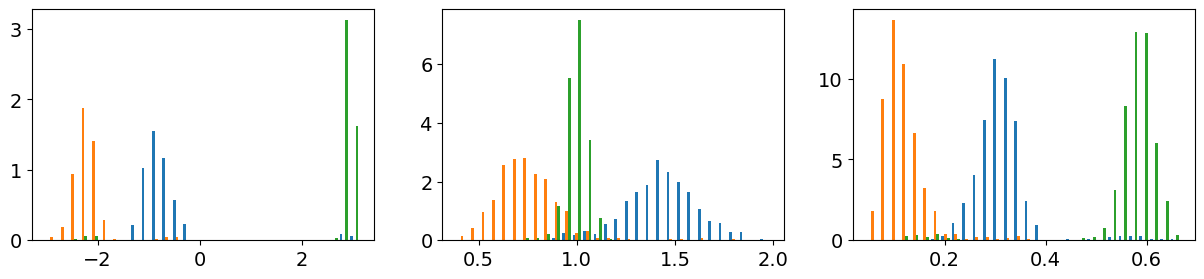

In [6]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
axes[0].hist(final_state.particles['mu'], bins=30, density=True)
axes[1].hist(final_state.particles['sd'], bins=30, density=True)
axes[2].hist(jax.vmap(centered_softmax)(final_state.particles['w_raw']), bins=30, density=True);

In [7]:
def centered_softmax(v):
    return jax.nn.softmax(jnp.insert(v, 0, 0, axis=0))

#
def plot_posterior(smpls, K, degree):
    nbins=40

    _, axes = plt.subplots(nrows=K, ncols=degree+1, constrained_layout=True, figsize=(8, K*2), sharex='col', sharey='col')
    for k in range(K):
        for j in range(degree+1):        
            axes[k, j].hist(smpls['eta'][:, k, j].flatten(), bins=nbins, density=True)
            axes[k, j].set_xlabel(r'$\eta_{{{:s}}}$'.format(f'{k},{j}'))
        axes[k,0].set_ylabel(f'Component {k+1}')
    plt.suptitle('Coefficients for different polynomial orders')
    plt.show()

    _, axes = plt.subplots(nrows=1, ncols=K, constrained_layout=True, figsize=(8, 2), sharex=True, sharey=True)
    for k, ax in enumerate(axes):
        ax.hist(smpls['sigma'][:, k], bins=nbins, density=True)
        ax.set_xlabel(fr'$\sigma_{k+1}$')
    plt.suptitle('Observation noise per component')
    plt.show()

    beta = smpls['beta']
    w = jnp.squeeze(jax.vmap(centered_softmax, in_axes=0)(beta))

    _, axes = plt.subplots(nrows=1, ncols=K, constrained_layout=True, figsize=(8, 2), sharex=True, sharey=True)
    for k, ax in enumerate(axes):
        ax.hist(w[:, k], bins=nbins, density=True)
        ax.set_xlabel(fr'$w_{k+1}$')
    plt.suptitle('Component weight')
    plt.show()

#
def plot_fit(key, Y, smpls, K, degree, color=None, ax=None, title=None):
    N, T = Y.shape
    get_polynomial = lambda x, d: x**d
    x = jax.vmap(get_polynomial, in_axes=(None, 0))(jnp.linspace(0, 1, num=T), jnp.arange(degree + 1))
    
    num_smpls = smpls['beta'].shape[0]
    new_figure = False
    if ax is None:
        new_figure = True
        plt.figure(figsize=(12, 6))
        ax = plt.gca()
    if title is not None:
        ax.set_title(title, fontsize=MEDIUM_SIZE)

    if color is None:
        color = 'tab:orange'

    for i in range(0, num_smpls, 5):
        for k in range(K):
            eta = smpls['eta'][i, k, :]
            mu = jnp.dot(eta, x)
            ax.plot(x[1, :], mu, color=color, alpha=0.01)

    for i in range(T):
        key, subkey = jrnd.split(key)
        jitter = 0.005*jrnd.normal(subkey, shape=(N, ))
        ax.plot(jitter+x[1, i], Y[:, i], '.', color='k', alpha=0.5)
   
    if new_figure:        
        ax.set_ylabel('GPA', fontsize=MEDIUM_SIZE)
    ax.set_xlabel('Semester', fontsize=MEDIUM_SIZE)
    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([1.0, 4.5])
    ax.set_xticks(jnp.linspace(0, 1, T), jnp.arange(T) + 1, fontsize=SMALL_SIZE)
    ax.tick_params(axis='y', labelsize=SMALL_SIZE)

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    if new_figure:
        plt.show()
    return ax

#
def data_fit(model, samples):
    loglikelihood_fn = model.loglikelihood_fn()
    LL = jnp.mean(jax.vmap(loglikelihood_fn)(samples))
    return LL

#
def KL_MC(p, q, supp, epsilon=1e-8):
    px = p(supp) + epsilon
    qx = q(supp) + epsilon  
    return 1 / len(px) * jnp.sum(px*(jnp.log(px) - jnp.log(qx)))

#

In [8]:
url = 'https://jasp-stats.org/wp-content/uploads/2022/02/gpa.csv'
df = pd.read_csv(url)

Y = df[['gpa1', 'gpa2', 'gpa3', 'gpa4', 'gpa5', 'gpa6']].to_numpy()
N, T = Y.shape

In [9]:
def centered_softmax(v):
    return jax.nn.softmax(jnp.insert(v, 0, 0, axis=0))

#
def grmm_link_fn(w_raw, beta, sd, x):
    mu = jnp.dot(beta, x)
    w = jnp.expand_dims(centered_softmax(w_raw), axis=1) * jnp.ones((1, T))
    sd = jnp.expand_dims(sd, axis=1) * jnp.ones((1, T))
    return dict(mixture_distribution=dx.Categorical(probs=w.T),
                components_distribution=dx.Normal(loc=mu.T, scale=sd.T))

#

GrMM = Model('Growth mixture model')

degree = 1
K = 4

get_polynomial = lambda x, d: x**d
X = jax.vmap(get_polynomial, in_axes=(None, 0))(jnp.linspace(0, 1, num=T), jnp.arange(degree + 1))

w_node = GrMM.add_node('w_raw', distribution=dx.Normal(loc=0.0, scale=1.0), shape=(K-1, ))
beta_node = GrMM.add_node('beta', distribution=dx.Normal(loc=0.0, scale=2.0), shape=(K, degree + 1))
sd_node = GrMM.add_node('sd', distribution=dx.Transformed(dx.Normal(loc=0.0, scale=1.0), tfb.Exp()), shape=(K, ))
x_node = GrMM.add_node('X', observations=X)
y_node = GrMM.add_node('Y', 
                      observations=Y, 
                      distribution=dx.MixtureSameFamily,
                      link_fn=grmm_link_fn,
                      parents=dict(w_raw=w_node, beta=beta_node, sd=sd_node, x=x_node))

GrMM.print_gibbs()

Gibbs structure:
w_raw               : p(Y | w_raw, X, beta, sd) p(w_raw)
beta                : p(Y | w_raw, beta, X, sd) p(beta)
sd                  : p(Y | w_raw, beta, X, sd) p(sd)


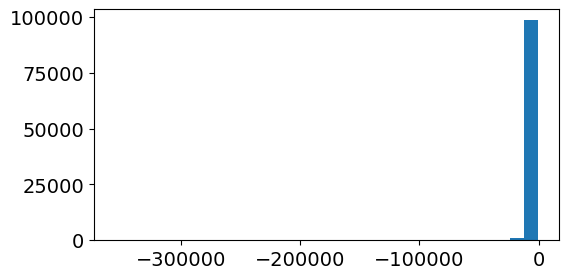

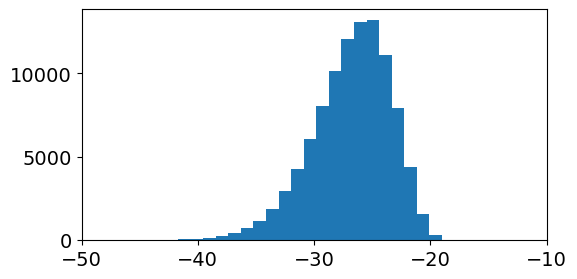

In [20]:
key = jrnd.PRNGKey(42)

key, subkey = jrnd.split(key)
keys = jrnd.split(subkey, 100000)
loglikelihood_fn = GrMM.loglikelihood_fn()
logprior_fn = GrMM.logprior_fn()
prior_samples = jax.vmap(GrMM.sample_prior)(keys)

lls = jax.vmap(loglikelihood_fn)(prior_samples)
lps = jax.vmap(logprior_fn)(prior_samples)

plt.figure(figsize=(6, 3))
plt.hist(lls, bins=30)
# plt.xlim([-30000, 0]);

plt.figure(figsize=(6, 3))
plt.hist(lps, bins=30)
plt.xlim([-50, -10]);

In [28]:
prior_samples['sd'][0, ...]

Array([0.41883885, 0.45024366, 1.44490859, 0.0835745 ], dtype=float64)

In [29]:
fixed_state = dict(beta=jnp.array([[-1.0, 1.2], [-2.7, -0.7], [2.2, -0.5], [-1.6, -3.7]]),
                   w_raw=jnp.array([-0.7, -1.0, 1.1]),
                   sd=jnp.array([0.2, 0.5, 1.1, 0.1]))

print(loglikelihood_fn(fixed_state))
print(logprior_fn(fixed_state))

-4853.382836057329
-24.305258210741464


In [59]:
mu = jnp.dot(fixed_state['beta'], X)
w = jnp.expand_dims(centered_softmax(fixed_state['w_raw']), axis=1) * jnp.ones((1, T))
sd = jnp.expand_dims(fixed_state['sd'], axis=1) * jnp.ones((1, T))
mixture_params = dict(mixture_distribution=dx.Categorical(probs=w.T),
                      components_distribution=dx.Normal(loc=mu.T, scale=sd.T))

ll = jnp.sum(dx.MixtureSameFamily(**mixture_params).log_prob(value=Y))
print(ll)

ll_ = 0
for t in range(T):
    mu_t = mu[:, t]
    ll_ += jnp.sum(dx.MixtureSameFamily(mixture_distribution=dx.Categorical(probs=centered_softmax(fixed_state['w_raw'])), components_distribution=dx.Normal(loc=mu_t, scale=fixed_state['sd'])).log_prob(value=Y[:, t]))

print(ll_)

ll__ = 0
for i in range(N):
    tmp = []
    for k in range(K):
        gauss_contr = jnp.sum(dx.Normal(loc=mu[k, :], scale=fixed_state['sd'][k]).log_prob(value=Y[i, :]))
        weight_contr = jnp.log(centered_softmax(fixed_state['w_raw'])[k])
        tmp.append(gauss_contr + weight_contr)
    ll__ += jax.scipy.special.logsumexp(jnp.array(tmp))

print(ll__)

-4853.382836057329
-4853.382836057329
-2270.570094776128


We are probably confusing batching and event dims, so that we mix up sum/logsumexp calls. Can we still do this in the distrax approach or should we implement a new Distribution? Perhaps we add some implicit dimensions?

In [45]:
position = fixed_state
w = centered_softmax(position['w_raw'])
eta = position['beta']
mu = jnp.dot(eta, X)
sigma = position['sd']

def a_k(w_k, mu_k, sigma_k, y_i):
    return jnp.log(w_k) - T/2*jnp.log(2*jnp.pi*sigma_k**2) - 1 / (2*sigma_k**2) * jnp.sum((y_i - mu_k)**2)

#
def log_lik_y_i(y_i):
    return jax.scipy.special.logsumexp(jax.vmap(a_k, in_axes=(0, 0, 0, None))(w, mu, sigma, y_i))

#
loglik_k = jnp.sum(jax.vmap(log_lik_y_i, in_axes=0)(Y))

print(loglik_k)
#

-2270.570094776128


Previous implementation yields:

-2270.5698

-24.305258

Likelihood is very much off! Prior is correct (compared to previous implementation). Now to find what is wrong...

Evaluation of the prior is definitely faster in bamojax!

There seems to be a difference in the loglikelihood-distribution, even if small.

In [33]:
key = jrnd.PRNGKey(1234)
num_chains = 1
num_mcmc_steps = 1000
num_particles = 2000
stepsize = 0.01

mcmc_params = dict(sigma=stepsize*jnp.eye(GrMM.get_model_size()))
mcmc = mcmc_sampler(GrMM, mcmc_kernel=normal_random_walk, mcmc_parameters=mcmc_params)

key, subkey = jrnd.split(key)
final_state, lml, num_adapt, final_info = smc_inference_loop(subkey, model=GrMM, kernel=mcmc, num_particles=num_particles, num_mcmc_steps=num_mcmc_steps, num_chains=num_chains)

Original implementation takes 15 seconds with 2000 particles and 1000 MCMC steps, AND is correct... (note that the time probably has to due with the problem rather than being an implementation detail)

In [38]:
from blackjax.diagnostics import potential_scale_reduction

for var, values in final_state.particles.items():
    R = potential_scale_reduction(values)
    print(f'R-hat ({var})')
    print(R)

print('Acceptance rates:')
print(jnp.mean(final_info.update_info.is_accepted, axis=(1, 2)))


R-hat (beta)
[[2.88760521 6.08012375]
 [4.43190547 4.84186618]
 [4.41541184 1.8079249 ]
 [5.25272507 5.42189167]]
R-hat (sd)
[ 2.56131789 16.25973705  1.95572446  5.43939334]
R-hat (w_raw)
[3.63539363 1.19118887 2.61127462]
Acceptance rates:
[7.9999998e-05 0.0000000e+00 4.8016998e-01 4.7145998e-01]


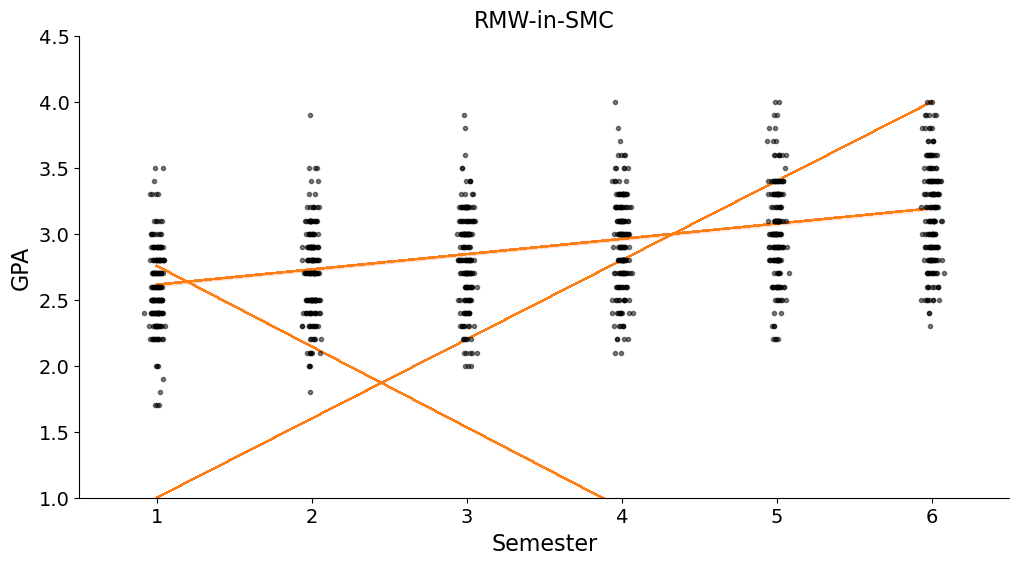

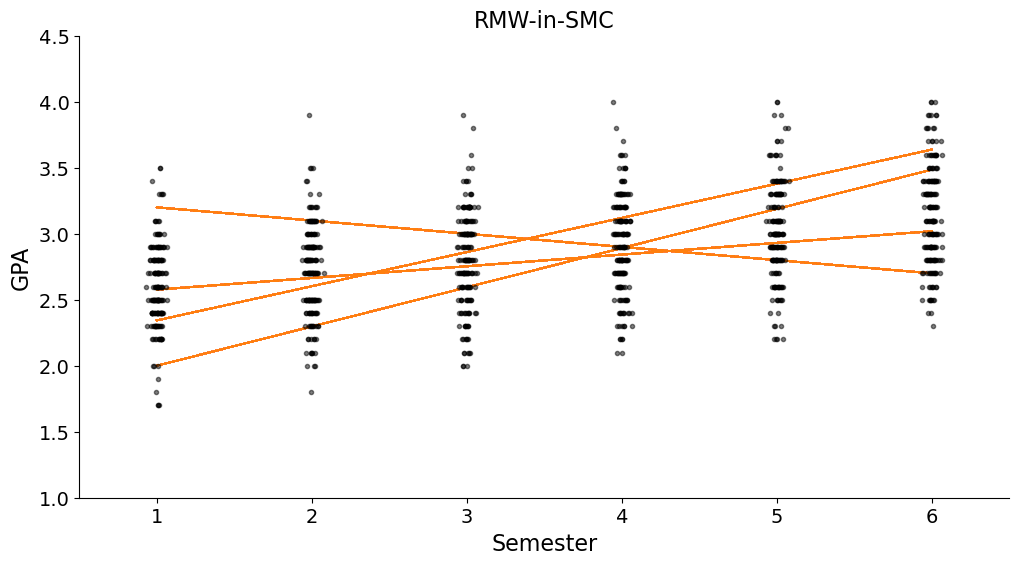

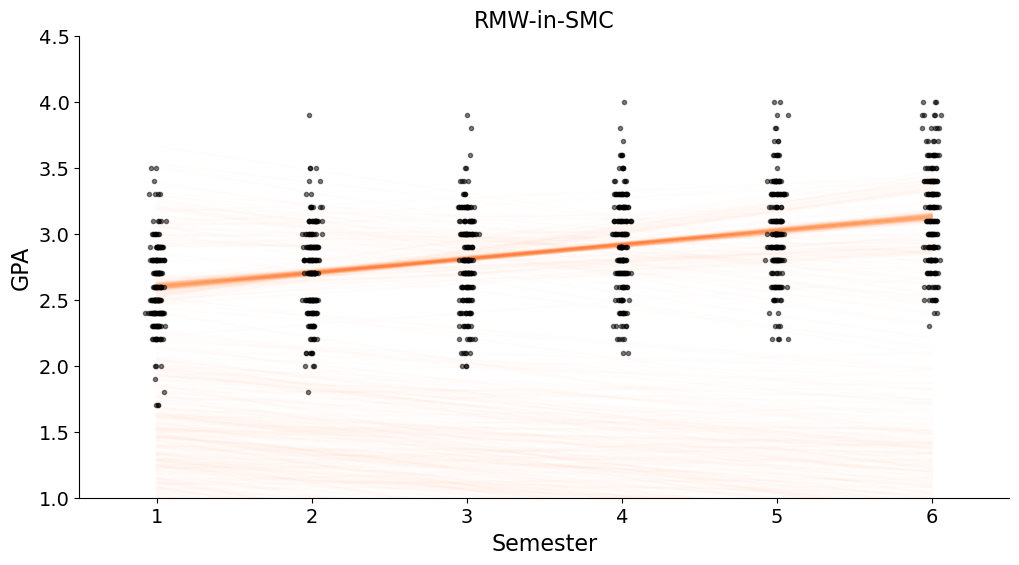

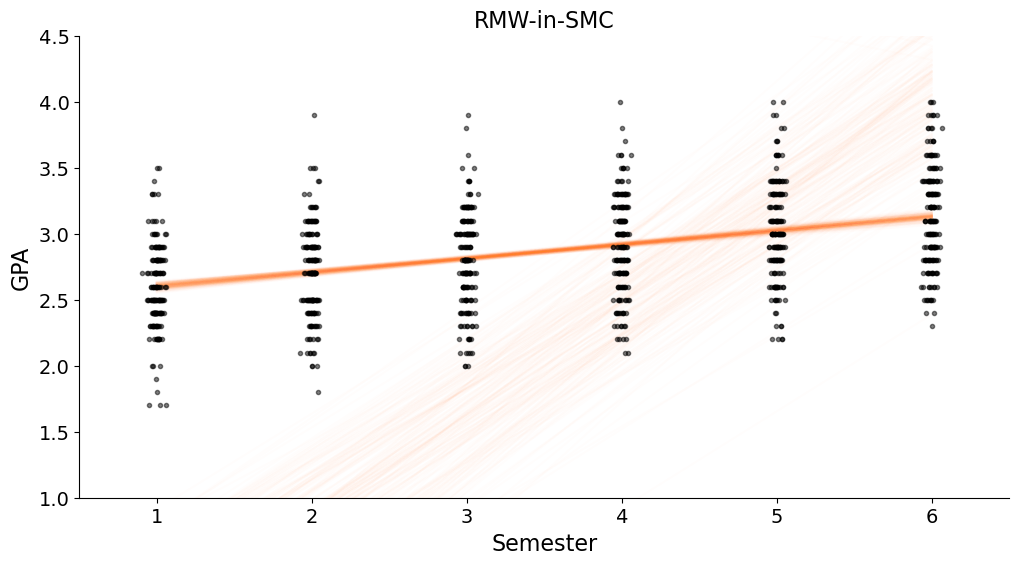

In [39]:
def plot_fit(key, Y, smpls, K, degree, color=None, ax=None, title=None):
    N, T = Y.shape
    get_polynomial = lambda x, d: x**d
    x = jax.vmap(get_polynomial, in_axes=(None, 0))(jnp.linspace(0, 1, num=T), jnp.arange(degree + 1))
    
    num_smpls = smpls['beta'].shape[0]
    new_figure = False
    if ax is None:
        new_figure = True
        plt.figure(figsize=(12, 6))
        ax = plt.gca()
    if title is not None:
        ax.set_title(title, fontsize=MEDIUM_SIZE)

    if color is None:
        color = 'tab:orange'

    for i in range(0, num_smpls, 5):
        for k in range(K):
            beta = smpls['beta'][i, k, :]
            mu = jnp.dot(beta, x)
            ax.plot(x[1, :], mu, color=color, alpha=0.01)

    for i in range(T):
        key, subkey = jrnd.split(key)
        jitter = 0.005*jrnd.normal(subkey, shape=(N, ))
        ax.plot(jitter+x[1, i], Y[:, i], '.', color='k', alpha=0.5)
   
    if new_figure:        
        ax.set_ylabel('GPA', fontsize=MEDIUM_SIZE)
    ax.set_xlabel('Semester', fontsize=MEDIUM_SIZE)
    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([1.0, 4.5])
    ax.set_xticks(jnp.linspace(0, 1, T), jnp.arange(T) + 1, fontsize=SMALL_SIZE)
    ax.tick_params(axis='y', labelsize=SMALL_SIZE)

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    if new_figure:
        plt.show()
    return ax

#


for c in range(num_chains):
    key, subkey = jrnd.split(key)
    plot_fit(subkey, Y, jax.tree.map(lambda x: x[c, ...], final_state.particles), K, degree, title='RMW-in-SMC');

It seems we run into some instablities, nothing is accepted. Should we not use distrax for mixture models? Can we add a custom, but more efficient, distribution object to bamojax instead?

See this code snippet from the old implementation:

```
def loglikelihood_fn_(state: GibbsState, Y = None) -> Float:
            if Y is None:
                Y = self.Y
            position = getattr(state, 'position', state)
            w = centered_softmax(position['beta'])
            eta = position['eta']
            mu = jnp.dot(eta, self.X)
            sigma = position['sigma']
            _, T = self.Y.shape

            def a_k(w_k, mu_k, sigma_k, y_i):
                return jnp.log(w_k) - T/2*jnp.log(2*jnp.pi*sigma_k**2) - 1 / (2*sigma_k**2) * jnp.sum((y_i - mu_k)**2)
            
            #
            def log_lik_y_i(y_i):
                return logsumexp(jax.vmap(a_k, in_axes=(0, 0, 0, None))(w, mu, sigma, y_i))
            
            #
            loglik_k = jnp.sum(jax.vmap(log_lik_y_i, in_axes=0)(Y))
            return loglik_k
        #
        return loglikelihood_fn_

    #
```

Here, we should replace the `1/2*jnp.log(2*jnp.pi*sigma_k**2) - 1 / (2*sigma_k**2) * jnp.sum((y_i - mu_k)**2)` with the log density of the component distribution. Although this seems to be what distrax does as well...